In [1]:
import os
import json
from web3 import Web3, HTTPProvider

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from utils.subgraph_utils.convex_community import get_curve_fees
from utils.etherscan_utils import get_txes_between_blocks


In [2]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
web3 = Web3(HTTPProvider(f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}"))

In [3]:
pool_addr = "0x5a6A4D54456819380173272A5E8E9B9904BdF41B"
lp_token_addr = "0x5a6A4D54456819380173272A5E8E9B9904BdF41B"
threecrv_addr = "0x6c3F90f043a72FA612cbac8115EE7e52BDe6E490"
mim_addr = "0x99D8a9C45b2ecA8864373A26D1459e3Dff1e17F3"

In [4]:
admin_2 = "0xA464e6DCda8AC41e03616F95f4BC98a13b8922Dc"
admin = "0xeCb456EA5365865EbAb8a2661B0c503410e9B347"

In [5]:
pool_addr.lower()

'0x5a6a4d54456819380173272a5e8e9b9904bdf41b'

Need individual coin addrs:

In [6]:
with open("./3crv.json", 'r') as f:
    abi = json.load(f)
threecrv = web3.eth.contract(address=threecrv_addr, abi=abi)

with open("./mim.json", 'r') as f:
    abi = json.load(f)
mim = web3.eth.contract(address=mim_addr, abi=abi)

In [7]:
subgraph_tripool_fees = get_curve_fees(pool_token_addr=lp_token_addr)
blocks = list([int(i) for i in subgraph_tripool_fees.block.values])
subgraph_block_ranges = list(zip(blocks, blocks[1:]))
subgraph_tripool_fees.index = subgraph_tripool_fees.block

In [8]:
ecb_txes = get_txes_between_blocks(address=admin.lower(), from_block=blocks[0], to_block=blocks[-1])
ecb_tx_blocks = [int(i['blockNumber']) for i in ecb_txes]
admin_2_txes = get_txes_between_blocks(address=admin_2.lower(), from_block=blocks[0], to_block=blocks[-1])
admin_2_tx_blocks = [int(i['blockNumber']) for i in admin_2_txes]

tx_blocks = list(set(ecb_tx_blocks) - set(admin_2_tx_blocks))
tx_blocks = sorted(tx_blocks)
tx_blocks

[13049982,
 13049990,
 13050093,
 13050096,
 13050111,
 13050116,
 13050140,
 13050206,
 13050219,
 13090383,
 13090392,
 13090592,
 13090596,
 13090600,
 13090605,
 13090628,
 13141084,
 13141087,
 13141111,
 13141120,
 13141134,
 13141142,
 13141148,
 13141152,
 13141155,
 13141161,
 13141178,
 13141196,
 13141201,
 13141223,
 13141229,
 13141243,
 13141252,
 13141263,
 13141267,
 13141288,
 13141292,
 13141307,
 13141311,
 13141328,
 13141332,
 13141356,
 13141359,
 13141378,
 13141382,
 13141402,
 13141406,
 13141430,
 13141437,
 13141453,
 13141456,
 13183961,
 13183969,
 13183977,
 13183983,
 13184003,
 13184006,
 13184054,
 13184060,
 13184066,
 13184072,
 13184097,
 13184126,
 13184132,
 13184160,
 13184164,
 13184183,
 13184334,
 13226451,
 13226455,
 13226512,
 13226516,
 13226526,
 13226530,
 13226554,
 13273790,
 13273795,
 13273912,
 13273918,
 13273921,
 13273925,
 13273946,
 13273949,
 13322177,
 13322180,
 13322230,
 13322235,
 13322384,
 13322416,
 13322428,
 13322432,

In [21]:
fees_for_range = []
for block in tx_blocks:

    block_start = block - 1
    block_end = block + 1

    print(f"Chain checkoooor-ing blocks: {block_start}:{block_end}")

    mim_transfer_filter = mim.events.Transfer.createFilter(
        fromBlock=block_start,
        toBlock=block_end
    )
    all_transfers = mim_transfer_filter.get_all_entries()
    mim_fees = 0
    for transfer in all_transfers:

        to_address = transfer['args']['_to']
        from_address = transfer['args']['_from']
        value = transfer['args']['_value']
        block = transfer['blockNumber']
        tx_hash = transfer['transactionHash'].hex()

        if (
                from_address == pool_addr and
                to_address in [admin_2, admin]
        ):
            mim_fees += value*1e-18

    threecrv_transfer_filter = threecrv.events.Transfer.createFilter(
        fromBlock=block_start,
        toBlock=block_end
    )
    all_transfers = threecrv_transfer_filter.get_all_entries()
    threecrv_fees = 0
    for transfer in all_transfers:

        to_address = transfer['args']['_to']
        from_address = transfer['args']['_from']
        value = transfer['args']['_value']
        block = transfer['blockNumber']
        tx_hash = transfer['transactionHash'].hex()

        if (
                from_address == pool_addr and
                to_address in [admin_2, admin]
        ):
            threecrv_fees += value*1e-18

    dict_fees = {
        'block': block,
        'mim_fees': mim_fees,
        'threecrv_fees': threecrv_fees,
        'tx_hash': tx_hash
    }
    fees_for_range.append(dict_fees)

df_fees = pd.DataFrame(fees_for_range)
df_fees

Chain checkoooor-ing blocks: 13049981:13049983
Chain checkoooor-ing blocks: 13049989:13049991
Chain checkoooor-ing blocks: 13050092:13050094
Chain checkoooor-ing blocks: 13050095:13050097
Chain checkoooor-ing blocks: 13050110:13050112
Chain checkoooor-ing blocks: 13050115:13050117
Chain checkoooor-ing blocks: 13050139:13050141
Chain checkoooor-ing blocks: 13050205:13050207
Chain checkoooor-ing blocks: 13050218:13050220
Chain checkoooor-ing blocks: 13090382:13090384
Chain checkoooor-ing blocks: 13090391:13090393
Chain checkoooor-ing blocks: 13090591:13090593
Chain checkoooor-ing blocks: 13090595:13090597
Chain checkoooor-ing blocks: 13090599:13090601
Chain checkoooor-ing blocks: 13090604:13090606
Chain checkoooor-ing blocks: 13090627:13090629
Chain checkoooor-ing blocks: 13141083:13141085
Chain checkoooor-ing blocks: 13141086:13141088
Chain checkoooor-ing blocks: 13141110:13141112
Chain checkoooor-ing blocks: 13141119:13141121
Chain checkoooor-ing blocks: 13141133:13141135
Chain checkoo

,block,mim_fees,threecrv_fees,tx_hash
0,13049982,0,0.0,0x9b110e5f0fc66a114b6b27b08edf477970376b4286be...
1,13049990,0,0.0,0x2d2783c0600bf20dc0b346965558eda9d6e81d99cbcb...
2,13050093,0,0.0,0x2d2783c0600bf20dc0b346965558eda9d6e81d99cbcb...
3,13050096,0,0.0,0x2d2783c0600bf20dc0b346965558eda9d6e81d99cbcb...
4,13050111,0,0.0,0x2d2783c0600bf20dc0b346965558eda9d6e81d99cbcb...
...,...,...,...,...
163,13717485,0,0.0,0xfcce29fac7413a8040d2b94f9a9294bbdea1960de1fe...
164,13717490,0,0.0,0xfcce29fac7413a8040d2b94f9a9294bbdea1960de1fe...
165,13717496,0,0.0,0xe41581bc66fd514f813646652814d869772802677597...
166,13717519,0,0.0,0x8966339d7b8858dfaf82910dd9e814c92c9807eae8e1...


In [24]:
df_fees['total_fees'] = df_fees.mim_fees + df_fees.threecrv_fees
df_fees.index = df_fees.block
df_fees = df_fees.where(df_fees.total_fees > 0).dropna()
df_fees

,block,mim_fees,threecrv_fees,tx_hash,total_fees
block,,,,,
13141087,13141087.0,0.0,20415.714743,0x8d3ee6ba564378d593b4b89f599c248d6833675431cd...,20415.714743
13183969,13183969.0,0.0,26661.169891,0xd7400c8810b2ce59d261a5bfcfd237243e943ab39898...,26661.169891
13184132,13184132.0,0.0,52.442558,0xadf20bf46fdd85de0ce9fc63a9075d9fbac0d1889b51...,52.442558
13226455,13226455.0,0.0,41242.086418,0x604930e621edafa98daf59c33f808b1c6ce0e09a4ef8...,41242.086418
13273795,13273795.0,0.0,56961.519587,0x72095a7b426d6fcf7123e326ba164b6868d1ebf6bf4b...,56961.519587
13322180,13322180.0,0.0,62661.197829,0x68fb8c13fbd488edb202ce28a4650009173a943e4211...,62661.197829
13363613,13363613.0,0.0,84228.663777,0x6e297f7c95ace9783f45d73d985f9bffb44742df67df...,84228.663777
13409100,13409100.0,0.0,107905.246067,0x9597c2c26a4bed9a6ce727c1a92dd30a77af50a4bcce...,107905.246067
13450705,13450705.0,0.0,105771.202716,0x4d9dbe9e800bb2b4f01a749f08d87c7c61ba85d44fad...,105771.202716


In [29]:
print(df_fees.where(df_fees.total_fees == df_fees.total_fees.max()).tx_hash.dropna().values[0])

0x1493ed2b53bcac14b29e8ca4b1bfa5741bb6a553ccf34a1a34ced1d33a8b5679


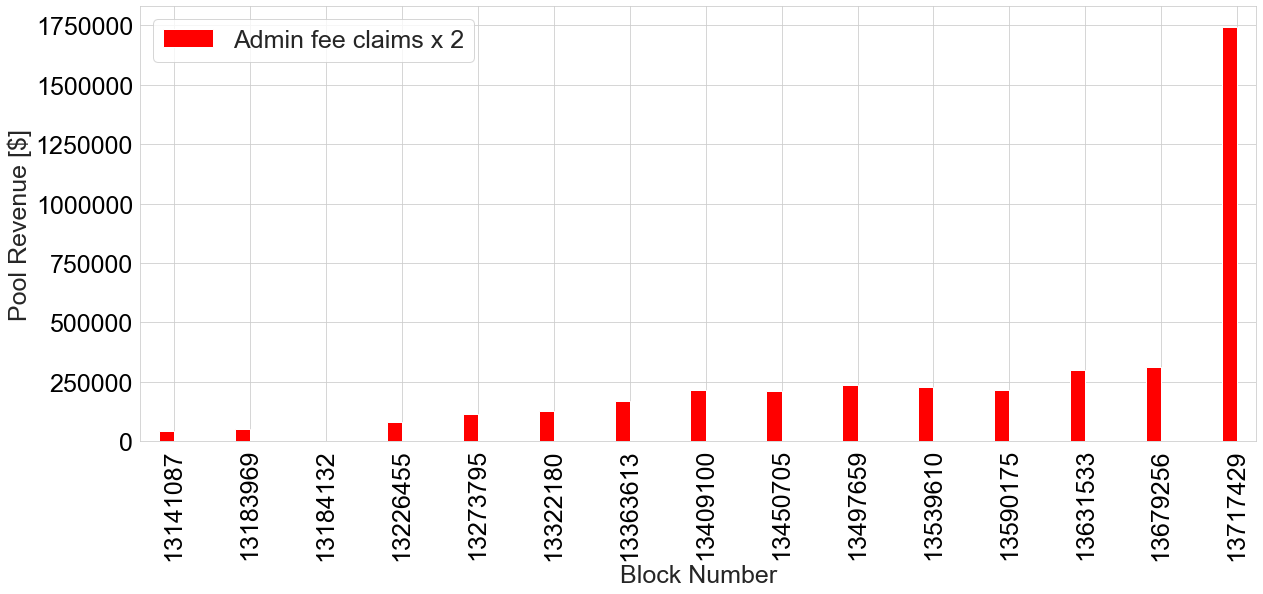

In [25]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

(df_fees['total_fees']*2).plot(
    ax=ax,
    color='red',
    kind='bar',
    label='Admin fee claims x 2',
    width=0.2,
    position=1,
)

ax.set_ylabel("Pool Revenue [$]", fontsize=25)
ax.set_xlabel("Block Number", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25, colors='black')
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.legend(fontsize=25);